## Buenos Aires Traffic Forecasting 

### Project Overview
* Analysed Buenos Aires 'Illia Highway' Toll Station data and produced a forecasting model for it's traffic flow using an XGBoost Regressor (RMSE=4540).
* Tested and optimized Random Forest and Gradient Boosting Regressors using GridsearchCV to reach the best model.
* Time Series, Series decomposition and Statistis analysis.
* Analyzed models errors, feature importances and residuals.

### Code and Resources Used 
**Python Version:** 3.7  
**Packages:** numpy, pandas, sklearn, matplotlib, seaborn, statsmodels.

### Dataset
The original yearly datasets are taken from the Autonomous City of Buenos Aires Government web and contains information of all highways toll stations that connect with the city.      
Data from years 2016 to 2019 was downloaded and a subset with only the data from 'Illia Highway' for type of payment 'cash' was built.  
Dataset: https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-de-peaje-ausa.  

### EDA
* Data time evolution and grouped distributions analysis.
* Outliers analysis and filtering.
* Stationarity, seasonality and autocorrelation analysis.
* Series decomposition.
* Feature engineering.

### Data Preparation
A Time Series with the toll station car passes data during the four years was built and used to construct a Dataframe with 3 months (90 days) lags per instance/date. Seven features created in the EDA section were added ending up with a Dataframe with 1370 instances (rows) and 97 features (columns). 
Data was splited into train (75%) and test (25%) sets.

### Models Building and Performance
Random Forest and Extreme Gradient Boosting Regressors models were developed and tuned using GridSearch. 

* **Random Forest Regressor**: RMSE=4691. 
* **XGBoost Regressor**: RMSE=4540.

### Metric Chosen
* **RMSE (Root Mean Squared Error)**: measures the Standard Deviation of residual values (differences between predicted and real values).  
    Reasons for the choise:    
    - Uses the same scale as the target variable "Price" (that's why we chose it instead of MSE).
    - It's easily differentiable, what makes it easy to use in conjunction with derivative-based methods like gradient descent (that's why we chose it instead of MAE).



### Notebook Content

1. Exploratory Data Analysis
2. Data Preparation
3. Models Training, evaluation and error analysis
4. Error analysis



## 1. Exploratory Data Analysis
---



In [1]:
import warnings
warnings.simplefilter('ignore')

Import libraries.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
sns.set() 

from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import xgboost

Import dataset:

In [3]:
data_2019 = pd.read_csv('Datasets/flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('Datasets/flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('Datasets/flujo-vehicular-2017.csv', sep =',')
data_2016 = pd.read_csv('Datasets/flujo-vehicular-2016.csv', sep =',')

In [114]:
data= pd.concat([data_2019, data_2018, data_2017, data_2016])

In [115]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4940149 entries, 0 to 1379442
Data columns (total 10 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   periodo         int64 
 1   fecha           object
 2   hora_inicio     int64 
 3   hora_fin        int64 
 4   dia             object
 5   estacion        object
 6   sentido         object
 7   tipo_vehiculo   object
 8   forma_pago      object
 9   cantidad_pasos  int64 
dtypes: int64(4), object(6)
memory usage: 414.6+ MB


Translate column names and neccesary feature categories:

In [116]:
data.rename(columns={'periodo': 'period', 'fecha': 'date', 'hora_inicio': 'hour_start', 'hora_fin': 'hour_end', 'dia': 'day', 
                     'estacion': 'station', 'sentido': 'direction', 'tipo_vehiculo': 'v_type', 'forma_pago': 'payment', 'cantidad_pasos': 'vehicles' }, inplace=True)

In [35]:
# data['payment'].unique()
# len(data['payment'].unique())

In [117]:
data['payment'] = data['payment'].map({'NO COBRADO': 'NOT CHARGED', 'TELEPASE': 'TELEPASS', 'EFECTIVO': 'CASH', 'EXENTO': 'EXEMPT', 'INFRACCION': 'INFRACTION',
       'T. DISCAPACIDAD': 'DISABILITY', 'TARJETA DISCAPACIDAD': 'DISABILITY CARD', 'MONEDERO': 'MONEDERO', 'Otros':'OTHERS',
       'AUPASS':'TELEPASS'})

In [118]:
ds = data.copy()

Data selection function:

In [81]:
def s_filter_1(data_selection, station_name, payment_type):
    mask = np.logical_and(data_selection.station==station_name, data_selection.payment ==payment_type)
    data_selection = data_selection[mask]
    data_selection.drop(columns = ['period','hour_start','payment', 'station'], inplace = True)
    data_selection['date2'] = pd.to_datetime(data_selection.date) + pd.to_timedelta(data_selection.hour_end, unit = 'h')
    data_selection.drop(columns=['date','hour_end'], inplace = True)
    data_selection.rename(columns = {'date2':'date'}, inplace = True) 
    data_selection.sort_values('date', inplace = True)
    data_selection.reset_index(drop=True, inplace = True)
    data_selection = data_selection.resample('D', on = 'date').sum()
   
    return data_selection

Outliers filter function:

In [82]:
def s_filter_2(data_selection):

    data_selection['vehicles'][data_selection['vehicles']<1000] = np.nan 
    data_selection = data_selection.interpolate()
    
    return data_selection

In [119]:
ds_1 = s_filter_1(ds, 'Illia','CASH')

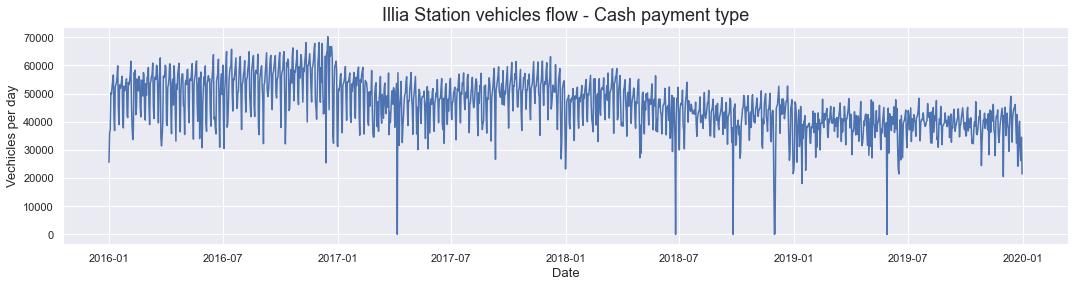

In [120]:
plt.figure(figsize = (18,4))

plt.plot(ds_1.index, ds_1.vehicles)

plt.title('Illia Station vehicles flow - Cash payment type', size=18)
plt.xlabel('Date', size= 13)
plt.ylabel('Vechicles per day', size= 13)
plt.show()

**Figure 1.** Number of vehicles per day in Illia station for cash payment type.

The filtered serie has a descendent trend and clearly visible outliers.

Outliers detection:

In [85]:
print(f'Outliers: {(ds_1.vehicles<1000).sum()}')

Outliers: 6


In [86]:
ds_1['vehicles'][ds_1['vehicles']<1000] 

date
2017-04-06     40
2018-06-25      0
2018-09-25      0
2018-11-30      0
2018-12-01    350
2019-05-29      0
Name: vehicles, dtype: int64

The outliers correspond to very low or null vehicles passes. Checking the dates of the outliers we could confirm that on 2017-04-06, 2018-06-25, 2018-09-25 and 2019-05-29 no payment where charged due to a union strike. And during the week of the remaining dates (2018-11-30 and 2018-12-01) there was a G20 Summit in Buenos Aires and highways functioning was affected by the event.

Outliers filtering and interpolation:

In [121]:
ds_2 = s_filter_2(ds_1)

In [122]:
print(f'Outliers: {(ds_2.vehicles<1000).sum()}')

Outliers: 0


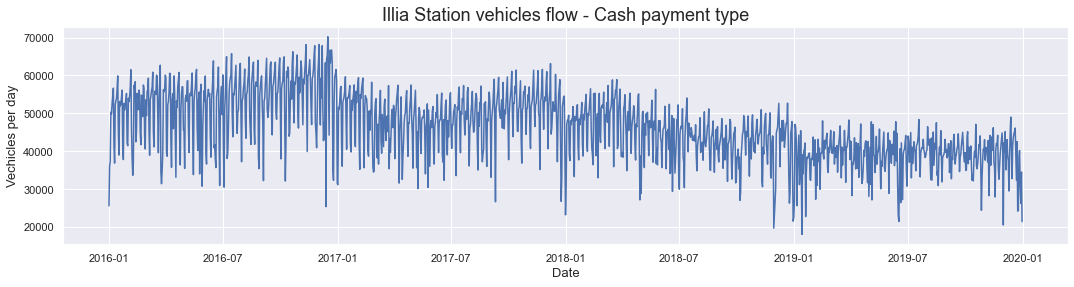

In [125]:
plt.figure(figsize = (18,4))

plt.plot(ds_2.index, ds_2.vehicles)

plt.title('Illia Station vehicles flow - Cash payment type', size=18)
plt.xlabel('Date', size= 13)
plt.ylabel('Vechicles per day', size= 13)
plt.show()

**Figure 2.** Vehicles per day in Illia Station for cash payment type with filtered outliers.

Null dates verification.  
(We generata a numeric index to analyse the `TimeIndex` as a common column feature).

In [74]:
ds_index = ds_2.copy()

In [75]:
ds_index.reset_index(inplace=True)
ds_index.head(1)

,date,vehicles
0,2016-01-01,25602.0


'date' is now a feature and we can verify null values.

In [76]:
ds_index['date_check'] = ds_index.date.diff()
ds_index.date_check.value_counts() 

1 days    1460
Name: date_check, dtype: int64

Difference between dates is always 1 so we can confirm there are no missing dates.

Null vehicles passes verification:

In [49]:
ds_2.isnull().sum()

vehicles    0
dtype: int64

Weekly traffic flow evolution:

In [52]:
by_weekday = ds_2.groupby(ds_2.index.dayofweek).mean() 
by_weekday.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'] 

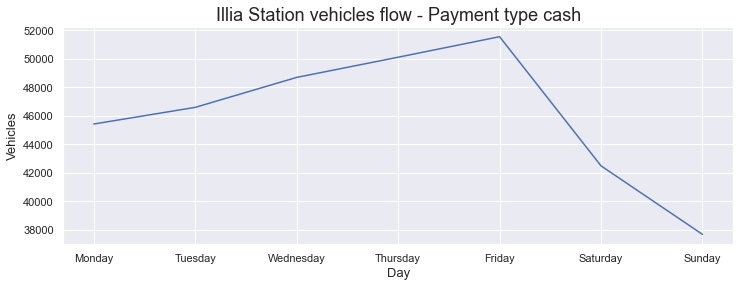

In [80]:
plt.figure(figsize=(12,4))

plt.plot(by_weekday)

plt.title('Illia Station vehicles flow - Payment type cash', size=18)
plt.xlabel('Day', size= 13)
plt.ylabel('Vehicles', size= 13)

plt.show()

**Figure 3.** Mean vehicles daily passes. 

As expected, traffic flow varies considerably depending on the day.

Daily traffic distribution for each year:

In [56]:
ds_days = ds_2.copy()

In [57]:
ds_days['day'] = ds_days.index.dayofweek

In [58]:
int(years[1])

2017

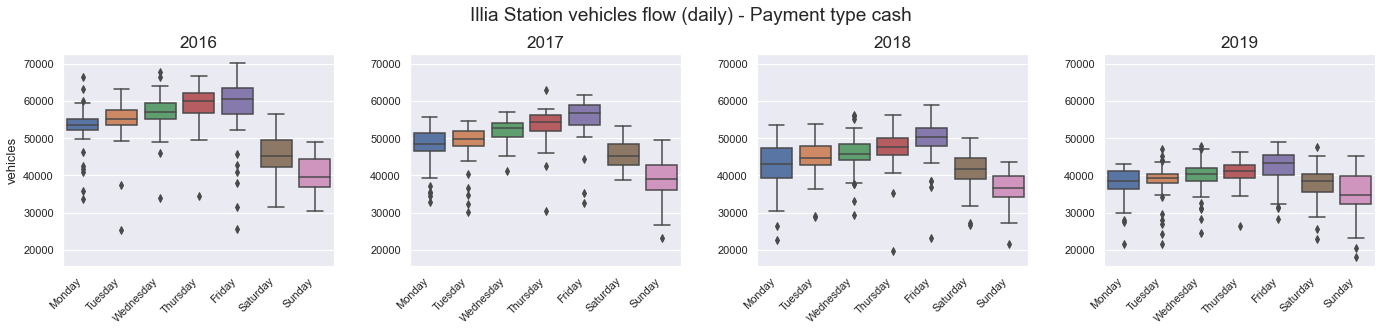

In [61]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5), sharey=True) 

years = ['2016', '2017', '2018', '2019']
ylabels = ['vehicles','', '', '']
xlabels = ['','', '', '']

for i in range(len(years)):
    
    plt.suptitle('Illia Station vehicles flow (daily) - Cash payment type', fontsize=19)
    ax[i] = plt.subplot(141+i, sharey=ax[i])
    sns.boxplot(ds_days[ds_days.index.year== int(years[i]) ]['day'], ds_days['vehicles'])
    plt.xlabel(xlabels[i], fontsize=13)
    plt.ylabel(ylabels[i], fontsize=13)
    plt.xticks([0, 1, 2, 3, 4, 5, 6], 
               ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], rotation=45, horizontalalignment='right')
    plt.title(years[i], fontsize=17)

plt.tight_layout(pad=3.0)
plt.subplots_adjust(top=0.85) 

plt.show()

**Figura 4.** Daily traffic flow distributions in Illia station for cash payment type for years 2016, 2017, 2018 and 2019.

Traffic flow for cash payment type has been decreasing through the years, specially on weekends. We'll analize this in section **Trend component Analysis**.

Traffic flow for each week of the year:

In [53]:
by_week = ds_2.groupby(ds_2.index.weekofyear).mean()

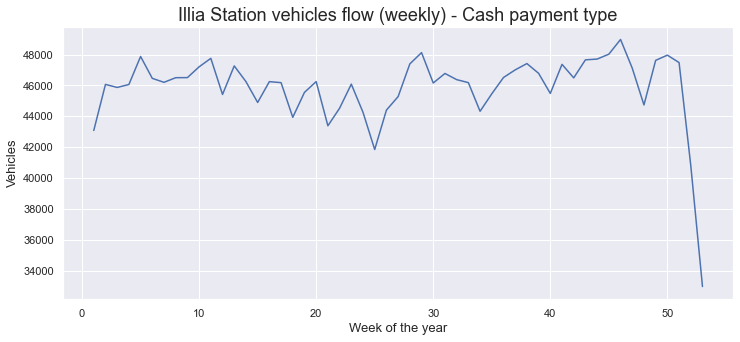

In [65]:
plt.figure(figsize=(12,5))

plt.plot(by_week)

plt.title('Illia Station vehicles flow (weekly) - Cash payment type', size=18)
plt.xlabel('Week of the year', size= 13)
plt.ylabel('Vehicles', size= 13)

plt.show()

**Figure 5.** Traffic flow mean per week.

Traffic flow varies depending on the week, with a notable descence during the last week of the year.

### Stationarity Analysis

Genereting moving averages for different days windows and the correspontants standard deviations:

In [90]:
y_hat_avg = ds_2.copy()
y_hat_avg['m_avg_7'] = y_hat_avg['vehicles'].rolling(7, center = True).mean() 
y_hat_avg['m_avg_14'] = y_hat_avg['vehicles'].rolling(14, center = True).mean() 
y_hat_avg['m_avg_30'] = y_hat_avg['vehicles'].rolling(30, center = True).mean() 
y_hat_avg['sd_avg_7'] = y_hat_avg['vehicles'].rolling(7, center = True).std() 
y_hat_avg['sd_avg_14'] = y_hat_avg['vehicles'].rolling(14, center = True).std() 
y_hat_avg['sd_avg_30'] = y_hat_avg['vehicles'].rolling(30, center = True).std() 

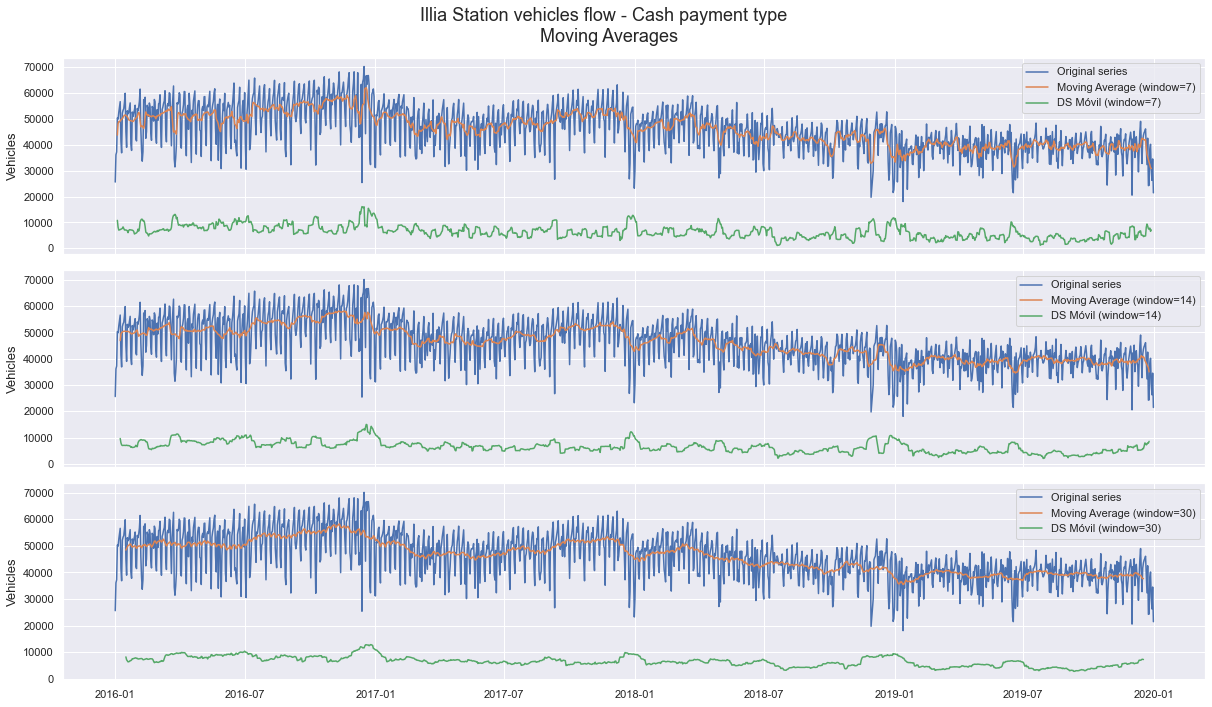

In [91]:
fig, ax = plt.subplots(3, 1, figsize=(17, 10), sharex=True) 
fig.suptitle('Illia Station vehicles flow - Cash payment type \n Moving Averages', fontsize=18) 

avgs = [7,14,30]
m_avgs = ['m_avg_7','m_avg_14','m_avg_30']
sd_avgs = ['sd_avg_7','sd_avg_14','sd_avg_30']

for i in range(len(m_avgs)):
    
    ax[i].plot(y_hat_avg['vehicles'], label='Original series')
    ax[i].plot(y_hat_avg[m_avgs[i]], label=f'Moving Average (window={avgs[i]})')
    ax[i].plot(y_hat_avg[sd_avgs[i]], label=f'DS Móvil (window={avgs[i]})')

    ax[i].set_ylabel('Vehicles', size=13)
    ax[i].legend()

fig.tight_layout() 
fig.subplots_adjust(top=0.91) 

plt.show()

**Figure 6.** Serie jointly represented with different windows moving averages and standard deviations.

Average (orange) and standard deviation (green) change over time, what indicates a **Non Stationary** series.

Dickey-Fuller Test:

In [77]:
from statsmodels.tsa.stattools import adfuller 

X = ds_2.values 
result = adfuller(X) 

print(' ADF Statistic: %f' % result[0]) 
print(' p-value: %f' % result[1]) 
print(' Critical Values:' ) 

for key, value in result[4].items(): 
    print(' \t%s: %.3f' % (key, value))

 ADF Statistic: -1.341200
 p-value: 0.610119
 Critical Values:
 	1%: -3.435
 	5%: -2.864
 	10%: -2.568


p-value > 0.05 so that the Null Hypothesis (Non Stationary serie) is not rejected, what indicates again we are in presence of a **Non Stationary** series.

Figure 6 and Dickey_Fuller Test let us conclude the series is **Non Stationary**: it's defined by a trend, meaning it's dependant on time, and mean and variance vary with it.


### Seasonality analysis

We'll zoom in the Lineplot looking into a 1 month period:

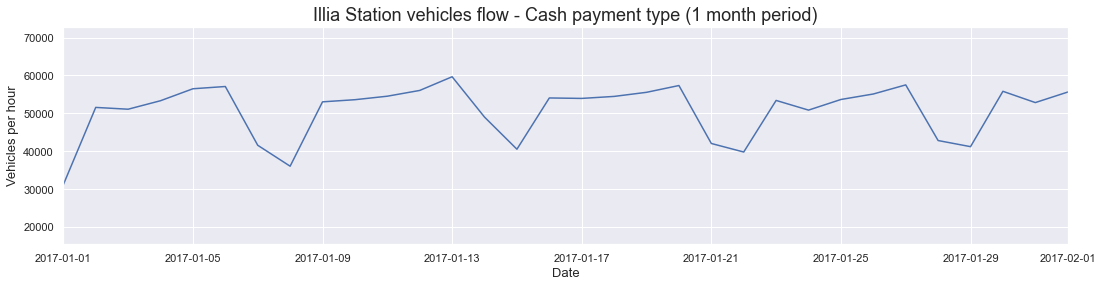

In [78]:
plt.figure(figsize=(18,4))

plt.plot(ds_2.index, ds_2.vehicles)

plt.title('Illia Station vehicles flow - Cash payment type (1 month period)', size=18)
plt.xlabel('Date', size= 13)
plt.ylabel('Vehicles per hour', size= 13)
plt.xlim(datetime.date(2017,1,1), datetime.date(2017,2,1))

plt.show()

**Figure 7.** Vehicles per day in 1 month period.

There's a clear cycle that repeats with a weekly frequence (stationality).

### Autocorrelation analysis

In [79]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

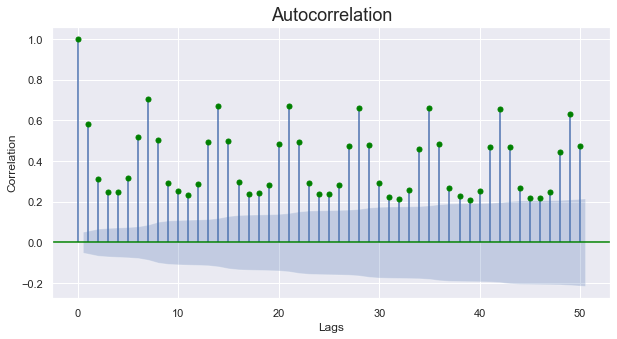

In [80]:
plt.rc("figure", figsize=(10,5))

plot_acf(ds_2['vehicles'], lags=50, color='green')

plt.title('Autocorrelation', size=18)
plt.xlabel('Lags')
plt.ylabel('Correlation')

plt.show();

**Figure 8.** Series autocorrelations from lag 0 to 50.

Autocorrelation is high every 7 days and variates cyclically, keeping the same pattern weekly.

### Partial autocorrelation

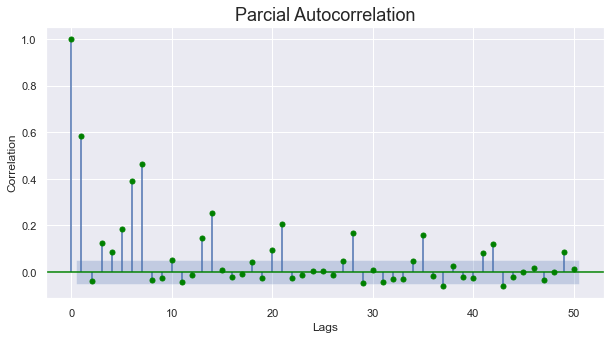

In [81]:
plt.rc("figure", figsize=(10,5))

plot_pacf(ds_2['vehicles'], lags=50, color='green')

plt.title('Parcial Autocorrelation', size=18)
plt.xlabel('Lags')
plt.ylabel('Correlation')

plt.show();

**Figure 9.** Series partial autocorrelation from lag 0 to 50.

Informative autocorrelation are the ones from the first 7 lags, and the rest are informatively redundat with those. Then keeps some correlation every 7 days probably due to the descendant trend of the series.

Lagplot of series with higher correlation lag (lag 7):

In [83]:
from pandas.plotting import lag_plot

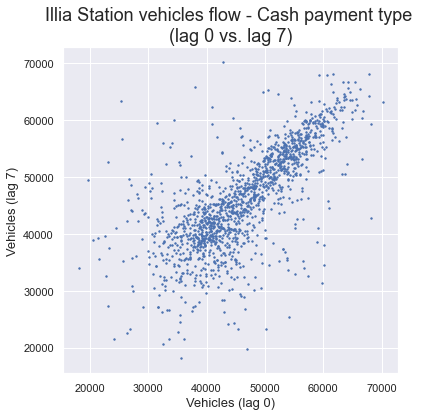

In [85]:
plt.figure(figsize=(6,6))
    
lag_plot(ds_2, lag=7, s=2, c='b')

plt.title('Illia Station vehicles flow - Cash payment type \n(lag 0 vs. lag 7)', size=18)
plt.xlabel('Vehicles (lag 0)', size= 13)
plt.ylabel('Vehicles (lag 7)', size= 13)

plt.show();

**Figure 10.** Series Lagplot in lag 0 and lag 7.

Diagonal concentrated dots show the correlation between lag 0 and lag 7  of the variable.

Figure 8, Autocorrelation and Partial Autocorrelation graphs let us conclude the series ahs a cyclic structure that repeats with the same frequency so that we confirm the series is **Seasonal**.


### Series decomposition

In [168]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [169]:
s_decompose = seasonal_decompose(ds_2['vehicles'], model = 'aditive')

In [170]:
original = s_decompose.observed
trend_component = s_decompose.trend
seasonal_component = s_decompose.seasonal
residual_component = s_decompose.resid

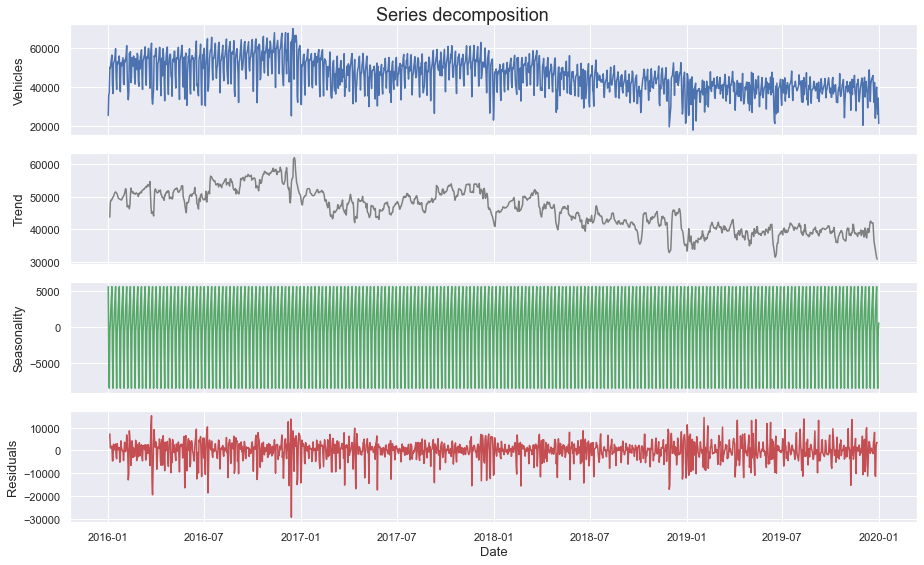

In [171]:
fig, ax = plt.subplots(4, 1, figsize=(13, 8), sharex=True)    ## AHORA ES LOOPEABLE
fig.suptitle('Series decomposition', fontsize=18) 

ax[0].plot(original)
ax[0].set_ylabel('Vehicles', size=13)

ax[1].plot(trend_component, c='grey')
ax[1].set_ylabel('Trend', size=13)

ax[2].plot(seasonal_component, c='g')
ax[2].set_ylabel('Seasonality', size=13)

ax[3].plot(residual_component, c='r')
ax[3].set_ylabel('Residuals', size=13)
ax[3].set_xlabel('Date', size=13)

fig.tight_layout() 
fig.subplots_adjust(top=0.95) 

plt.show()

**Figure 11.** Original series Lineplots (blue) and it's components: Trend (grey), Sationality (green) and Residuals (red).

We can check again the decreasing trend and the continuos frequency cycle of the seasonal component.

Statistics analysis:

In [42]:
ds.describe()

,cantidad_pasos
count,1461.000000
mean,46072.497947
std,8762.413312
min,18076.000000
25%,39703.000000
50%,45596.000000
75%,52832.000000
max,70203.000000


Mean is close to 46000, which we can consider the Level.

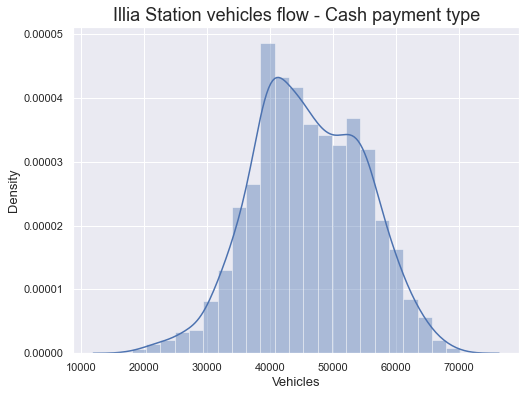

In [94]:
plt.figure(figsize=(8, 6))

sns.distplot(ds_2['vehicles'])

plt.title('Illia Station vehicles flow - Cash payment type', size=18)
plt.xlabel('Vehicles', size=13)
plt.ylabel('Density', size=13)
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False) 

**Figure 12.** Series values distribution.

The histogram shows a left-skew distribution.

### Trend Analysis

We'll analyse the traffic flow for a different payment type.

In [126]:
ds_ = data.copy()

In [127]:
ds_1_tele = s_filter_1(ds_, 'Illia', 'TELEPASS')

In [129]:
ds_2_tele = s_filter_2(ds_1_tele)

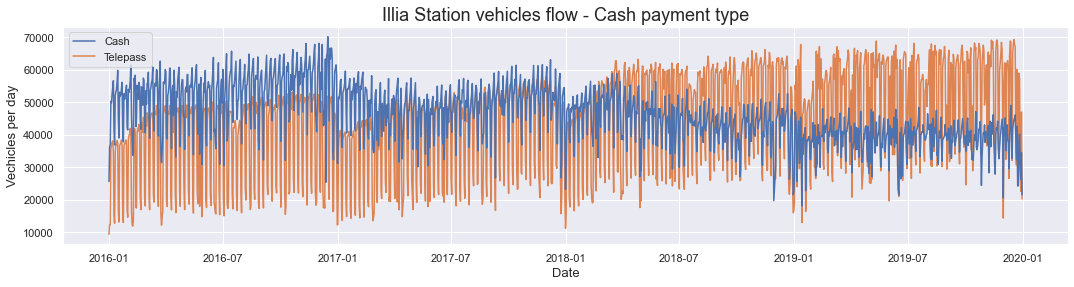

In [133]:
plt.figure(figsize = (18,4))

plt.plot(ds_2.index, ds_2.vehicles, label='Cash', zorder=2)
plt.plot(ds_2_tele.index, ds_2_tele.vehicles, label='Telepass', zorder=1)

plt.title('Illia Station vehicles flow - Cash payment type', size=18)
plt.xlabel('Date', size= 13)
plt.ylabel('Vechicles per day', size= 13)
plt.legend()
plt.show()

**Figure 13.** Traffic flow for Cash and Telepass payment types.

The plot evidences the descending trend in our series is due to the migration to an electronic payment type.

### Holydays dates analysis

info links: https://es.wikipedia.org/wiki/Anexo:D%C3%ADas_festivos_en_Argentina

Creating auxiliary dataset:

In [151]:
ds_holidays = ds_2.copy()

Loading holydays data:

In [152]:
holidays_full=pd.read_csv('datasets/holidays.csv', sep =';')

2020 info discard:

In [154]:
holidays = holidays_full[:36] 

Adding data to auxiliar dataset:

In [155]:
holidays['date_c']= pd.to_datetime(holidays['date'],dayfirst=True)
holidays.drop(columns='date',inplace=True)
holidays.rename(columns={'date_c':'date'}, inplace=True)
ds_holidays=ds_holidays.merge(holidays,on='date',how='left')
ds_holidays['holyday'].fillna(0, inplace=True)

Day type comparison:

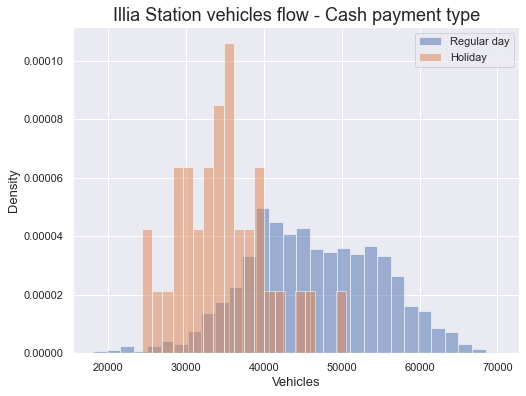

In [158]:
plt.figure(figsize=(8, 6))

ds_holidays.loc[ds_holidays['holyday']==0,'vehicles'].hist(density=True,alpha=0.5,label='Regular day', bins=30)
ds_holidays.loc[ds_holidays['holyday']==1,'vehicles'].hist(density=True,alpha=0.5,label='Holiday', bins=20)

plt.title('Illia Station vehicles flow - Cash payment type', size=18)
plt.xlabel('Vehicles', size=13)
plt.ylabel('Density', size=13)
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False) 

plt.legend()
plt.show()

**Figure 14.** Series values distribution for holidays and regular days.

As expected, the traffic flow varies considerably depending on the day type, having the holidays distribution a shorter range and been irregular in same sections.

## 2. Data Preparation
---



Data preparation function:

In [160]:
def data_preparation(data):
    
    N = data.shape[0] 
    X = np.zeros((N - look_back -1,look_back))
    y = np.zeros(N - look_back -1)            

    for i in range(X.shape[0]):
        X[i,:] = data.iloc[i:i+look_back]        
        y[i] = data.iloc[i+look_back]      
    
    return X, y

Train Test Split function (number of years for training and leap-year info are passed as arguments):

In [161]:
def train_test_split(X, y, n_years, bis1, bis2):
        
    N_train = n_years*365 + bis1 - look_back 
    N_test = 365 + bis2              
    N_total = N_train + N_test

    length_total = N_train + N_test + look_back

    X_train = X[:N_train,:]    
    y_train = y[:N_train]         

    X_test = X[N_train:N_train+N_test,:]
    y_test = y[N_train:N_train+N_test]
    
    return X_train, y_train, X_test, y_test, N_train, N_test, N_total, length_total

Train Test Split function for Dataframe format:

In [162]:
def train_test_split_df(X, y, n_years, bis1, bis2):
            
    N_train = n_years*365 + bis1 - look_back 
    N_test = 365 + bis2              
    N_total = N_train + N_test

    length_total = N_train + N_test + look_back

    X_train = Xdf.iloc[:N_train,:]     
    y_train = y[:N_train]         

    X_test = Xdf.iloc[N_train:N_train+N_test,:]
    y_test = y[N_train:N_train+N_test]
    
    return X_train, y_train, X_test, y_test, N_train, N_test, N_total, length_total

### New dataset construction.

The following features studied and recopilated in section 1 will be added to our dataframe:  
- Components
- Day of week  
- Week of year  
- Telepass
- Holiday

In [164]:
data = ds_2['vehicles']  
data.shape

(1461,)

In [165]:
look_back = 90

Features 'X' and Target 'y' selection:

In [166]:
X, y = data_preparation(data)

In [167]:
Xdf = pd.DataFrame(X)

In [172]:
Xdf['s_comp'] = trend_component.values[91:]
Xdf['t_comp'] = seasonal_component.values[91:]
Xdf['r_comp'] = residual_component.values[91:]

In [173]:
Xdf = Xdf.interpolate() 

In [174]:
Xdf['day'] = ds_2.index.dayofweek[91:]

In [175]:
Xdf['week'] = ds_2.index.weekofyear[91:]

In [176]:
Xdf['telepass'] = ds_2_tele['vehicles'].values[91:]

In [177]:
Xdf['holiday'] = ds_holidays['holyday'].values[91:]

Final dataset verification:

In [178]:
Xdf.head()

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,s_comp,t_comp,r_comp,day,week,telepass,holiday
0,25602.0,36136.0,37225.0,50312.0,49907.0,52492.0,54514.0,56645.0,41449.0,36882.0,...,56220.0,55669.0,56372.0,51701.285714,5559.855258,2176.859027,4,13,45922.0,0.0
1,36136.0,37225.0,50312.0,49907.0,52492.0,54514.0,56645.0,41449.0,36882.0,52186.0,...,55669.0,56372.0,60074.0,51344.285714,-3586.569192,-8254.716522,5,13,19692.0,1.0
2,37225.0,50312.0,49907.0,52492.0,54514.0,56645.0,41449.0,36882.0,52186.0,53295.0,...,56372.0,60074.0,59438.0,51207.714286,-8425.648377,-4096.065909,6,13,17972.0,0.0
3,50312.0,49907.0,52492.0,54514.0,56645.0,41449.0,36882.0,52186.0,53295.0,53885.0,...,60074.0,59438.0,39503.0,51279.428571,-658.385470,1545.956898,0,14,46281.0,0.0
4,49907.0,52492.0,54514.0,56645.0,41449.0,36882.0,52186.0,53295.0,53885.0,56429.0,...,59438.0,39503.0,38686.0,51423.571429,570.336371,1176.092201,1,14,47214.0,0.0


Train Test split:

In [179]:
X_train, y_train, X_test, y_test, N_train, N_test, N_total, length_total = train_test_split_df(Xdf, y, 3, 1, 0)

In [181]:
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape)) 
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))

X_train shape: (1006, 97)
y_train shape: (1006,)
X_test shape: (364, 97)
y_test shape: (364,)


### Standarization

In [183]:
scaler = StandardScaler()

X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

## 3. Models Training, evaluation and error analysis
---



RMSE calculation function:

In [184]:
def model_results(X_train, y_train, X_test, y_test, model, name):
    pred_model_train = model.predict(X_train)
    pred_model_test = model.predict(X_test)

    print(f'{name}:')
    print('RMSE in Train Set: {:.4f}'.format(np.sqrt(mean_squared_error(pred_model_train, y_train))))
    print('RMSE in Test Set: {:.4f}'.format(np.sqrt(mean_squared_error(y_test, pred_model_test))))  

Plotting functions:

In [219]:
def full_graph(X_train, X_test, ds, model, name):   

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    data=ds 
    
    plt.figure(figsize=(25,5))

    plt.plot(data.index[:length_total], data[:length_total], color='grey', label = 'Test Set')
    plt.plot(data.index[:N_train + look_back], data[:N_train + look_back],'', color='mediumseagreen', label = 'Train Set')
    plt.plot(data.index[look_back: look_back + N_train], y_train_pred,'-', color='b', label = 'Train Set prediction')
    plt.plot(data.index[N_train+look_back: length_total-1], y_test_pred,'', color='r', label = 'Test Set prediction')

    plt.title(f'Training and prediction\n {name} Model', size=18)
    plt.xlabel('Date', size=13)
    plt.ylabel('Vehicles', size=13)
    plt.legend()

    plt.show()

In [220]:
def full_graph_zoom(X_train, X_test, ds, model, name):   

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    data=ds 
    
    plt.figure(figsize=(25,5))

    plt.plot(data.index[:length_total], data[:length_total], color='grey', label = 'Test Set')
    plt.plot(data.index[:N_train + look_back], data[:N_train + look_back],'', color='mediumseagreen', label = 'Train Set')
    plt.plot(data.index[look_back: look_back + N_train], y_train_pred,'-', color='b', label = 'Train Set prediction')
    plt.plot(data.index[N_train+look_back: length_total-1], y_test_pred,'', color='r', label = 'Test Set prediction') 

    plt.title(f'Prediction\n {name} Model', size=18)
    plt.xlabel('Date', size=13)
    plt.ylabel('Vehicles', size=13)
    plt.xlim(datetime.date(2018,12,25), datetime.date(2020,1,1))
    plt.legend()

    plt.show()

Grid Search results function:

In [187]:
def grid_results(grid):
    print('Best hyperparameters:', grid.best_params_)

Feature importance plotting function:

In [188]:
def feature_importance_df(model, nombre):
    
    df=pd.DataFrame(Xdf)
    importances = model.feature_importances_
    columns = df.columns
    
    plt.figure(figsize=(25,5))
    
    sns.barplot(columns, importances)

    plt.title(f'Feature Importance\n Modelo {nombre}', fontsize=18)
    plt.xlabel('Features', fontsize=13)
    plt.ylabel('Importance', fontsize=13)
    plt.xticks(rotation=45, horizontalalignment='right')
    
    plt.show()

In [189]:
def feature_importance(model, nombre):
    
    df=pd.DataFrame(X)
    importances = model.feature_importances_
    columns = df.columns
    
    plt.figure(figsize=(25,5))
    
    sns.barplot(columns, importances)

    plt.title(f'Feature Importance\n Modelo {nombre}', fontsize=18)
    plt.xlabel('Features', fontsize=13)
    plt.ylabel('Importance', fontsize=13)
    plt.xticks(rotation=45)
    
    plt.show()

### Model 1: Random Forest

In [190]:
forest = RandomForestRegressor(random_state=42, n_jobs=-1)

In [98]:
param_grid_f = {'n_estimators': [100, 200, 400, 500], 
                'max_features': [10, 20, 30, 50, 60], 
                'max_depth': [5, 10, 20, 40, 60, None]}   

In [100]:
grid_search_f = GridSearchCV(forest, param_grid_f, cv=5,  n_jobs=-1)

In [101]:
grid_search_f.fit(X_train_sc, y_train) 

GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20, 40, 60, None],
                         'max_features': [10, 20, 30, 50, 60],
                         'n_estimators': [100, 200, 400, 500]})

In [102]:
grid_results(grid_search_f)

Mejores Hiperparámetros: {'max_depth': 10, 'max_features': 50, 'n_estimators': 200}


Training the model with grid search parameters results:

In [193]:
forest = RandomForestRegressor(max_features=50, n_estimators=200, max_depth=10, n_jobs=-1, random_state=42)

In [195]:
forest.fit(X_train_sc, y_train)

RandomForestRegressor(max_depth=10, max_features=50, n_estimators=200,
                      n_jobs=-1, random_state=42)

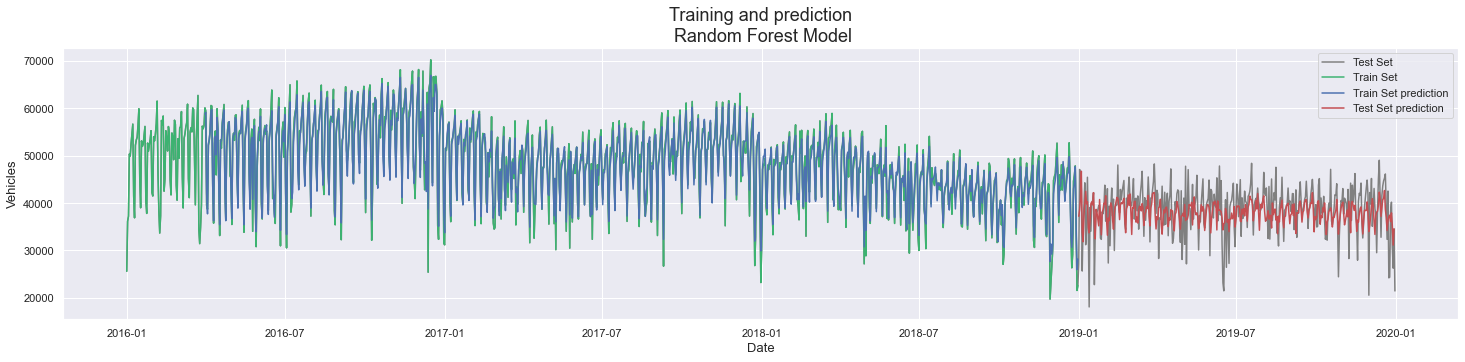

In [221]:
full_graph(X_train_sc, X_test_sc, ds_2['vehicles'], forest, 'Random Forest')

**Figure 15.** Train Set (green) and Test Set (gray) of original series with both sets predictions (blue for Train set and red for Test set).

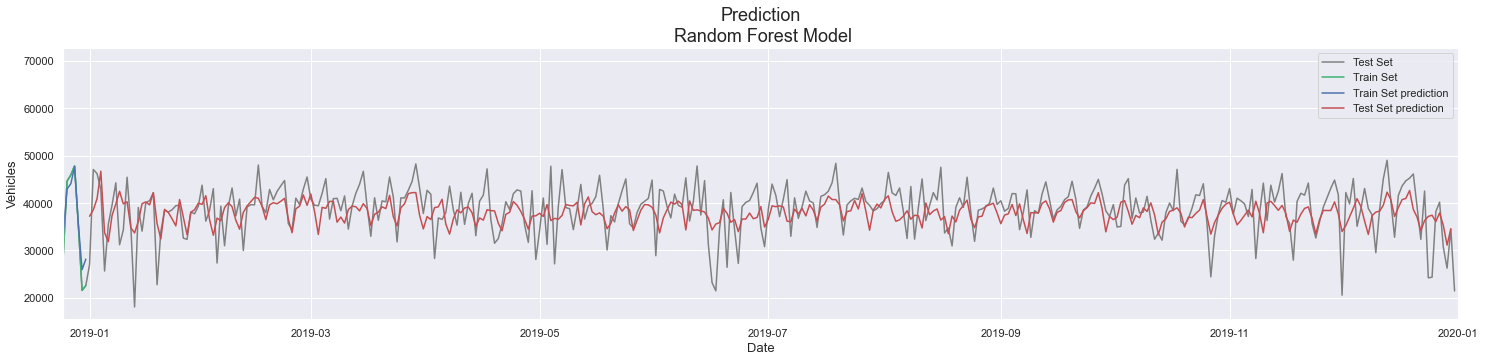

In [222]:
full_graph_zoom(X_train_sc, X_test_sc, ds_2['vehicles'], forest, 'Random Forest')

**Figure 16.** Train Set (green) and Test Set (gray) of original series with both sets predictions (blue for Train and red for Test).

Model evaluation:

In [200]:
model_results(X_train_sc, y_train, X_test_sc, y_test, forest, 'Random Forest')

Random Forest:
RMSE in Train Set: 1940.1948
RMSE in Test Set: 4691.6533


### Features importance analysis

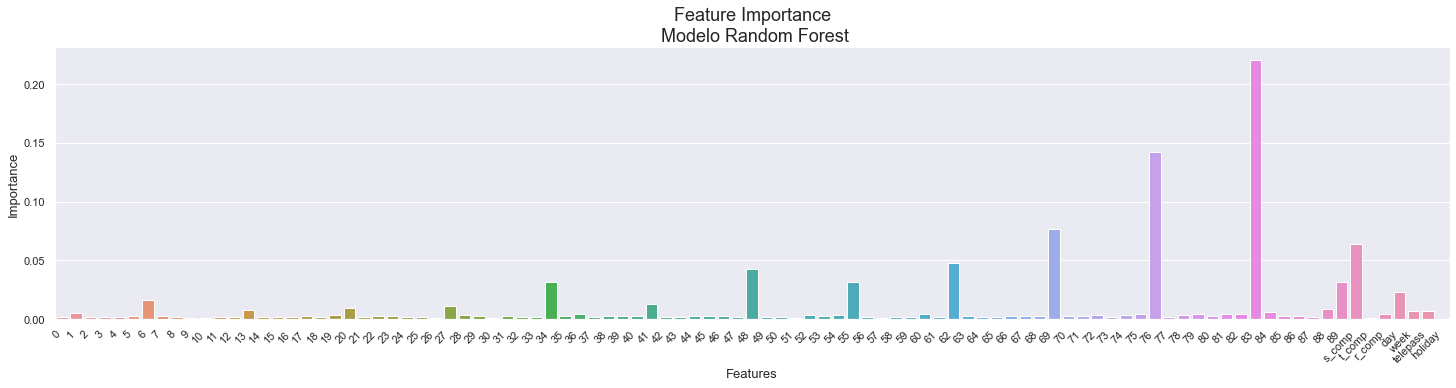

In [202]:
feature_importance_df(forest, 'Random Forest')

**Figure 17.** Importance of each feature during Random Forest model building.

The features that show more importance are the ones correspondent to lags multiple of 7. This is explained by the correlation found every 7 days and with the frequence-7 cycle that describes the series seasonality. The most important feature is definitely the correspondent to the lag 1 week before to the prediction (data of the same day of the week before). The algorithm also used the new features to build the model.

### Model 2: XGBoost

In [223]:
import xgboost

In [224]:
print(xgboost.__version__)

1.3.3


In [225]:
xgb = xgboost.XGBRegressor()

In [652]:
# xgb = xgboost.XGBRegressor(random_state=42, n_jobs=-1)

In [43]:
from sklearn.model_selection import TimeSeriesSplit

In [74]:
tscv = TimeSeriesSplit(n_splits=5)

In [651]:
param_grid_xgb = {'n_estimators': [500, 600, 700], 
                  'colsample_bytree': [0.8, 0.9], 
                  'max_depth': [2, 3, 5],
                  'eta':[0.01, 0.1, 0.5], 
                  'reg_lambda':[1.0, 1.5, 2.0], 
                  'reg_alpha':[1.0, 1.5, 2.0]
                  }   

In [77]:
grid_search_xgb = GridSearchCV(xgb, param_grid_xgb, cv=tscv,  n_jobs=-1)

In [654]:
grid_search_xgb.fit(X_train_sc, y_train) #-> 21 min

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=-1,
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_paramete

In [79]:
grid_results(grid_search_xgb)

Mejores Hiperparámetros: {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 2, 'n_estimators': 700, 'reg_alpha': 1.5, 'reg_lambda': 1.5}


Training the model with grid search parameters results:

In [229]:
xgb = xgboost.XGBRegressor(colsample_bytree=0.9, reg_lambda=1.5, n_estimators=600, eta=0.01, reg_alpha=1.5, max_depth=2, n_jobs=-1, random_state=42)

In [230]:
xgb.fit(X_train_sc, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, eta=0.01, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.00999999978, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=600, n_jobs=-1, num_parallel_tree=1, random_state=42,
             reg_alpha=1.5, reg_lambda=1.5, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [231]:
model_results(X_train_sc, y_train, X_test_sc, y_test, xgb, 'XGBoost')

XGBoost:
RMSE in Train Set: 3670.9419
RMSE in Test Set: 4540.2814


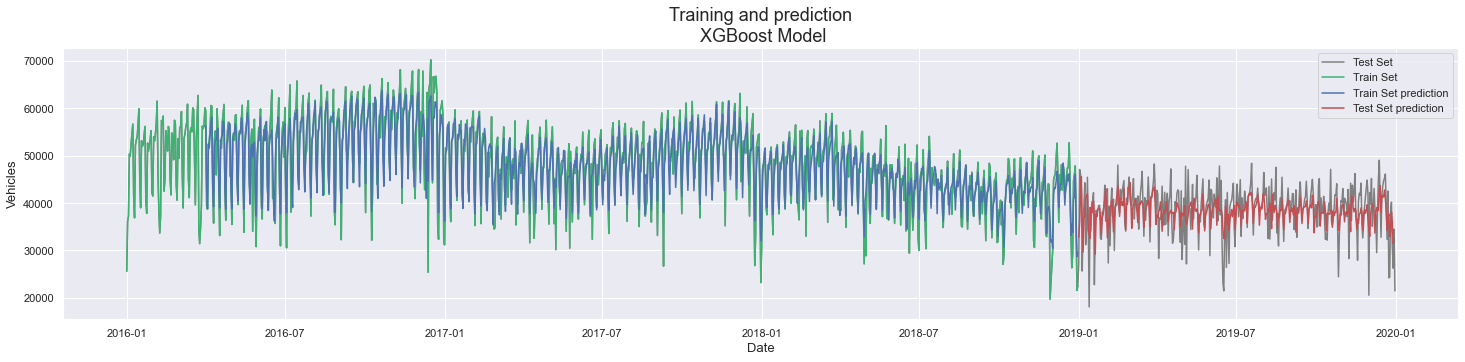

In [233]:
full_graph(X_train_sc, X_test_sc, ds_2['vehicles'], xgb, 'XGBoost')

**Figure 18.** Train Set (green) and Test Set (gray) of original series with both sets predictions (blue for Train set and red for Test set).

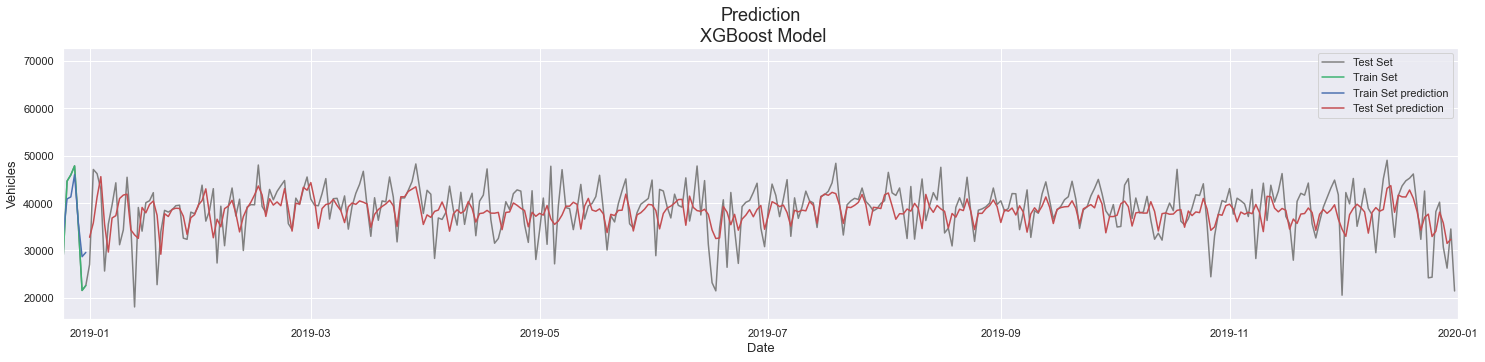

In [235]:
full_graph_zoom(X_train_sc, X_test_sc, ds_2['vehicles'], xgb, 'XGBoost')

**Figure 19.** Train Set (green) and Test Set (gray) of original series with both sets predictions (blue for Train and red for Test).

### Features importance analysis

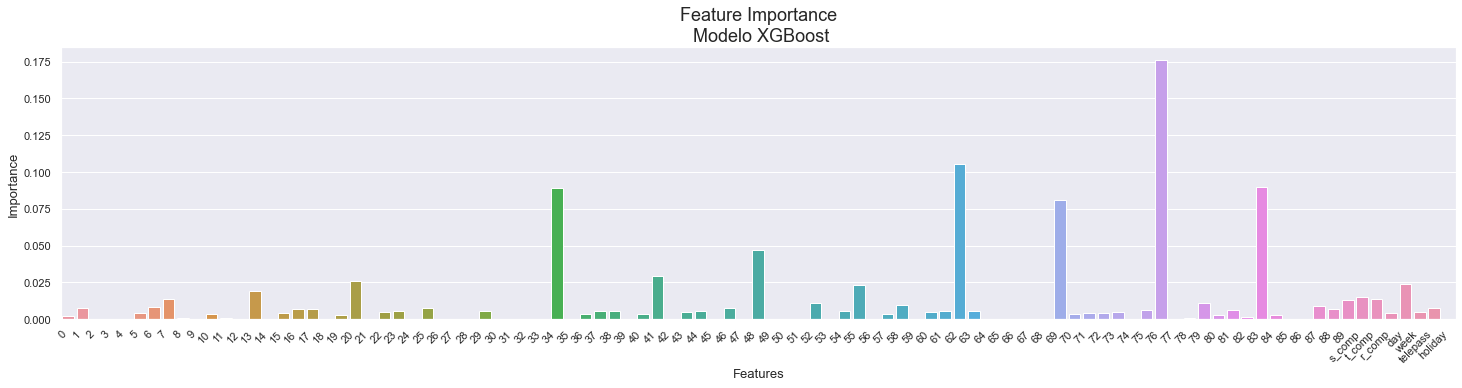

In [238]:
feature_importance_df(xgb, 'XGBoost')

**Figure 20.** Importance of each feature during XGBoost model building.

The feature importance pattern is similar to the one of the Random Forest model, with the distinction that the most important feature is the correspondent to the lag 2 weeks before the prediction.

### Results recopilation

In [245]:
formt = lambda x: float("{:.4f}".format(x))

regressor = ['Random Forest', 'XGBoost']
models = [forest, xgb]
R2_Train, R2_Test, RMSE_Train, RMSE_Test = [], [], [], []

for m in models:
    RMSE_Train.append(formt(np.sqrt(mean_squared_error(m.predict(X_train_sc), y_train))))
    RMSE_Test.append(formt(np.sqrt(mean_squared_error(y_test, m.predict(X_test_sc)))))

results = pd.DataFrame({'RMSE Train':RMSE_Train,'RMSE Test':RMSE_Test}, index=regressor)
results

,RMSE Train,RMSE Test
Random Forest,1940.1948,4691.6533
XGBoost,3670.9419,4540.2814


The XGBoost model outperformed the Random Forest Model so we will continue analyzing its performance.

## 4. Error analysis

We analyze the dispersion plot of the XGBoost model results: 

In [239]:
y_train_pred = xgb.predict(X_train_sc)
y_test_pred = xgb.predict(X_test_sc)

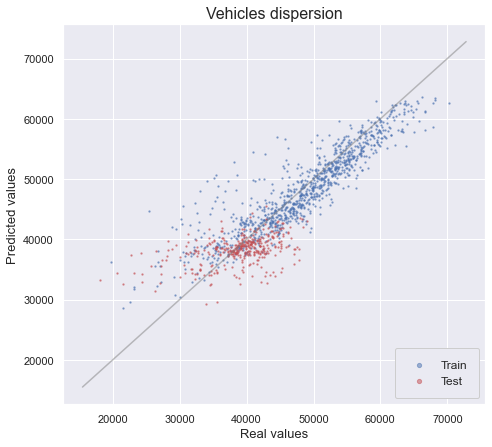

In [240]:
plt.figure(figsize = (7,7))

ax = plt.subplot()

ax.scatter(y_train, y_train_pred, s=2, color='b', alpha=0.5, label='Train')
ax.scatter(y_test, y_test_pred, s=2, color='r', alpha=0.5, label='Test')

lims = [np.min([ax.get_xlim(), ax.get_ylim()]),  
        np.max([ax.get_xlim(), ax.get_ylim()])]

plt.legend(fancybox=True, framealpha=10, borderpad=1, markerscale=3, scatterpoints=1, fontsize=12, loc="lower right")
ax.plot(lims, lims, 'grey', alpha=0.5, zorder=1)
plt.title('Vehicles dispersion', fontsize=16)
plt.xlabel('Real values', size=13)
plt.ylabel('Predicted values', size=13)

plt.tight_layout()
plt.subplots_adjust(top=0.85) 

plt.show()

**Figure 21.** Predicted values vs. Real values dispersion on Train and Test sets.

The red dots more disperse than the blue ones explain the RMSE difference between Train and Test sets. The grouping of the red dots below 45000 is due to the descendant trend: the Test set has the last year (lowest values) data.

Residuals analysis:

In [241]:
residual_train = y_train - y_train_pred
residual_test = y_test - y_test_pred

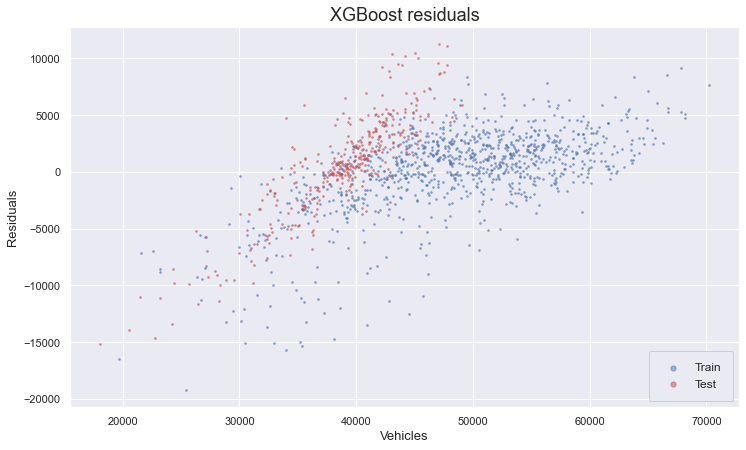

In [244]:
plt.figure(figsize = (12,7))

plt.scatter(y_train, residual_train, c='b', s=3, alpha=0.5, label='Train')
plt.scatter(y_test, residual_test, c='r', s=3, alpha=0.5, label='Test')

plt.legend(fancybox=True, framealpha=10, borderpad=1, markerscale=3, scatterpoints=1, fontsize=12, loc="lower right")
plt.title('XGBoost residuals', fontsize=18)
plt.xlabel('Vehicles', fontsize=13)
plt.ylabel('Residuals', fontsize=13)
plt.show()

**Figure 22.** Gradient Boosting model residuals in Train and Test sets.

Positive values indicate subvaluation and negatives overvaluation (Residual = Real value - Predicted value).

Red dots are concentrated near 4000, value near the level of the series section correspondant to Test set (year 2019).  To the left and the right of this region we in we see respectively the overvaluation and subvaluation of the XGBoost.